# Project Model - Stephanie and Belu

Approach 1: Uses upper and lower molars from each species to train a model to predict the species class (Dinohippus interpolatus, Dinohippus mexicanus, and Equus simplicidens).  
Approach 2: Uses only upper or lower molars from from each of the species to train a model to predict the species class (Dinohippus interpolatus, Dinohippus mexicanus, and Equus simplicidens).

In [1]:
# Import libraries
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import ImageFolder
from torchvision import datasets, transforms, models
from torch.utils.data import Subset
from torch.utils.data import DataLoader
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

os.environ['KERAS_BACKEND'] = 'torch'
from PIL import Image
from keras.preprocessing import image as image_utils
from keras.applications.densenet import preprocess_input, decode_predictions

import shutil
import keras
import pickle
import random
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from keras.preprocessing import image as image_utils
from keras.applications.densenet import preprocess_input
from keras.applications.densenet import decode_predictions

from keras.layers import Dense

import copy

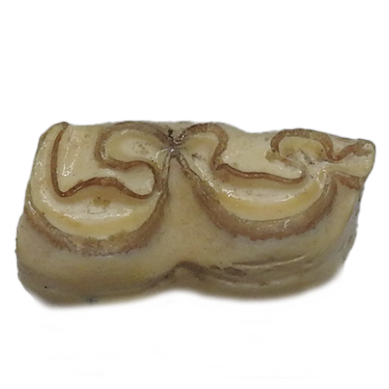

Image loaded successfully!


In [2]:
from PIL import Image
import matplotlib.pyplot as plt

file_path = "/lustre/fs0/bsc4892/skillingsworth/Project/Project/Images/Interpolatus_Lowers_Crop/1.png"

try:
    img = Image.open(file_path)  # Open the image with PIL
    plt.imshow(img)
    plt.axis("off")  # Hide axis
    plt.show()
    print("Image loaded successfully!")
except Exception as e:
    print("Error loading image:", e)

In [3]:
current_directory = os.getcwd()
print(current_directory)

/lustre/fs0/bsc4892/skillingsworth/Project/Project


In [4]:
# Define paths
image_dir = "/lustre/fs0/bsc4892/skillingsworth/Project/Project/Images"

In [5]:
import shutil
import os

checkpoint_path = os.path.join(image_dir, ".ipynb_checkpoints")
if os.path.exists(checkpoint_path):
    shutil.rmtree(checkpoint_path)

os.listdir(image_dir)

['Interpolatus_Lowers_Crop',
 'Simplicidens_Uppers_Crop',
 'Mexicanus_Lowers_Crop',
 'Simplicidens_Lowers_Crop',
 'Mexicanus_Uppers_Crop',
 'Interpolatus_Uppers_Crop']

In [6]:
# Function to show the images
def show_image(base_dir, max_images=10):
    """
    Iterates through all subfolders, finds images, and displays them.
    
    Args:
    - base_dir: The main directory containing subfolders with images.
    - max_images: Maximum number of images to display (default: 10).
    """
    image_count = 0  # Track how many images are shown

    for subfolder in sorted(os.listdir(base_dir)):  # Sort for consistency
        subfolder_path = os.path.join(base_dir, subfolder)

        if os.path.isdir(subfolder_path):  # Ensure it's a folder
            print(f"Opening images from category: {subfolder}")

            for image_file in sorted(os.listdir(subfolder_path)):  # Sort for consistency
                image_path = os.path.join(subfolder_path, image_file)

                if os.path.isfile(image_path):  # Check if it's a file
                    try:
                        img = Image.open(image_path)
                        plt.figure()
                        plt.imshow(img)
                        plt.axis("off")
                        plt.title(f"{subfolder}: {image_file}")
                        plt.show()

                        image_count += 1
                        if image_count >= max_images:  # Stop after max_images
                            return
                    except Exception as e:
                        print(f"Error loading {image_file}: {e}")

# Function to load and process the image
def load_and_process_image(image_path):
    try:
        img = Image.open(image_path)
        print("Original image shape:", np.array(img).shape)  # Print original shape
        
        # Load image and resize to 224x224
        img = image_utils.load_img(image_path, target_size=(224, 224))
        img_array = image_utils.img_to_array(img)  # Convert to NumPy array
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
        img_array = preprocess_input(img_array)  # Preprocess for DenseNet

        print("Processed image shape:", img_array.shape)
        return img_array
    except Exception as e:
        print("Error processing image:", e)
        return None

# Function to make a prediction using DenseNet
def densenet_prediction(image_path, model):
    show_image(image_path)  # Display the image
    image = load_and_process_image(image_path)  # Process the image

    if image is not None:
        predictions = model.predict(image)  # Make a prediction
        print("Predicted:", decode_predictions(predictions, top=3))  # Decode results


Opening images from category: Interpolatus_Lowers_Crop


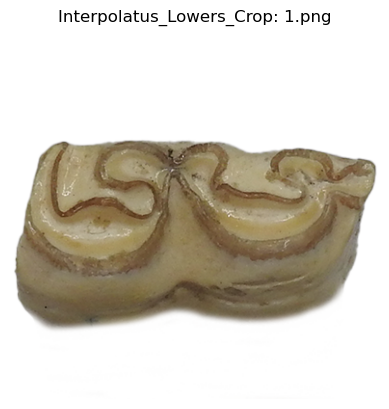

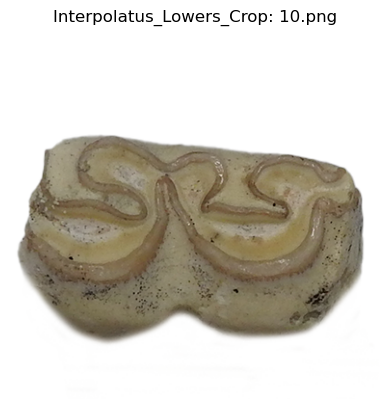

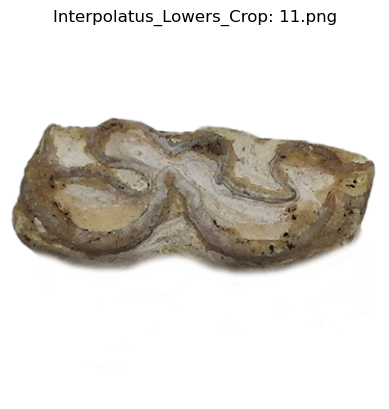

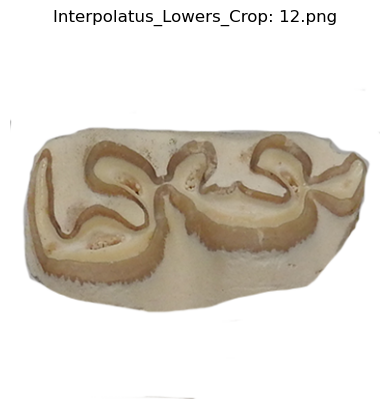

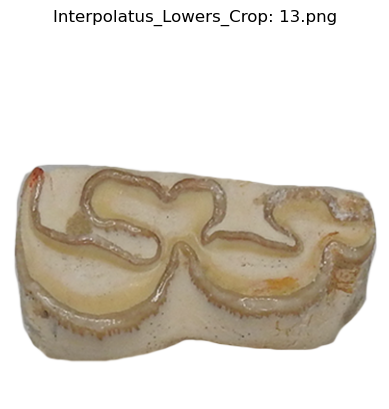

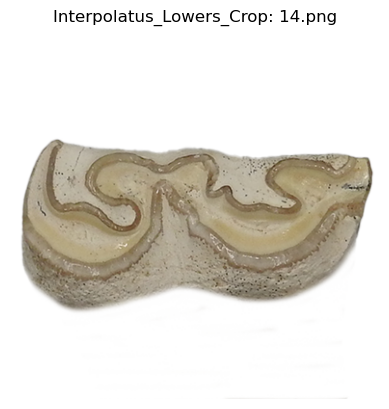

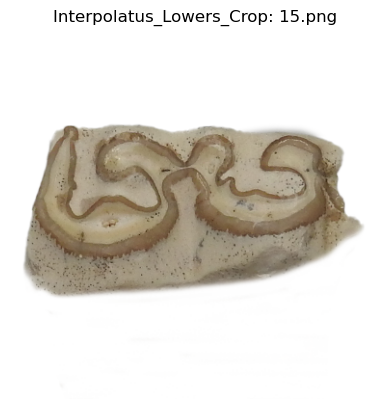

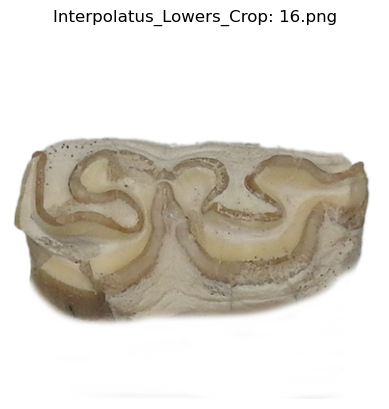

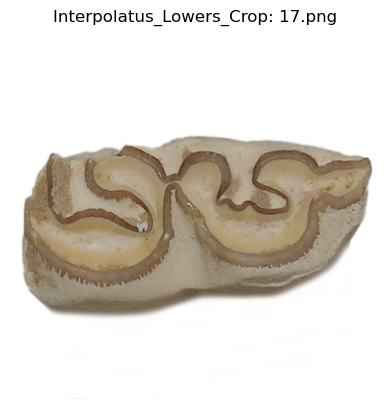

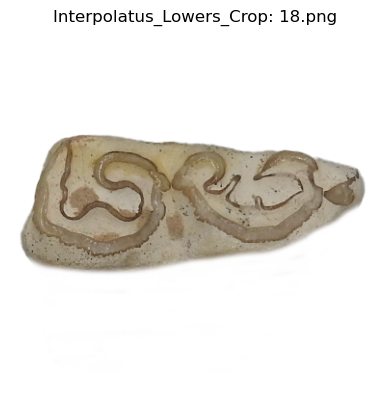

In [7]:
show_image(image_dir)

In [8]:
load_and_process_image(file_path)

Original image shape: (384, 384, 3)
Processed image shape: (1, 224, 224, 3)


array([[[[2.2489083, 2.4285715, 2.64     ],
         [2.2489083, 2.4285715, 2.64     ],
         [2.2489083, 2.4285715, 2.64     ],
         ...,
         [2.2489083, 2.4285715, 2.64     ],
         [2.2489083, 2.4285715, 2.64     ],
         [2.2489083, 2.4285715, 2.64     ]],

        [[2.2489083, 2.4285715, 2.64     ],
         [2.2489083, 2.4285715, 2.64     ],
         [2.2489083, 2.4285715, 2.64     ],
         ...,
         [2.2489083, 2.4285715, 2.64     ],
         [2.2489083, 2.4285715, 2.64     ],
         [2.2489083, 2.4285715, 2.64     ]],

        [[2.2489083, 2.4285715, 2.64     ],
         [2.2489083, 2.4285715, 2.64     ],
         [2.2489083, 2.4285715, 2.64     ],
         ...,
         [2.2489083, 2.4285715, 2.64     ],
         [2.2489083, 2.4285715, 2.64     ],
         [2.2489083, 2.4285715, 2.64     ]],

        ...,

        [[2.2489083, 2.4285715, 2.64     ],
         [2.2489083, 2.4285715, 2.64     ],
         [2.2489083, 2.4285715, 2.64     ],
         ...,


In [9]:
# Define transformations for training and validation
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [10]:
import os 
from torchvision.datasets import ImageFolder 
from torch.utils.data import Subset, DataLoader 
import random 
import copy 

# Step 1: Load dataset and map folder names 
dataset = ImageFolder(root=image_dir) 

# Step 2: Build mapping: original class idx -> new class idx based on first 5 letters 
folder_to_new_class = {} 
new_class_name_to_idx = {} 
next_class_idx = 0  

for folder_name in dataset.classes: 
    key = folder_name[:5] 
    if key not in new_class_name_to_idx: 
        new_class_name_to_idx[key] = next_class_idx 
        next_class_idx += 1 
    folder_to_new_class[folder_name] = new_class_name_to_idx[key] 

# Step 3: Relabel targets 
remapped_targets = [folder_to_new_class[dataset.classes[target]] for target in dataset.targets]  

# Step 4: Group indices by new class labels 
unique_classes = set(remapped_targets) 
class_indices = {c: [] for c in unique_classes} 
for idx, target in enumerate(remapped_targets): 
    class_indices[target].append(idx)  

# Step 5: Stratified train/val split 
train_indices = [] 
val_indices = [] 

for class_label, indices in class_indices.items(): 
    n_samples = len(indices) 
    n_train = max(int(n_samples * 0.8), 1) 
    n_val = max(1, n_samples - n_train)  
    random.shuffle(indices) 
    train_indices.extend(indices[:n_train]) 
    val_indices.extend(indices[-n_val:]) 
random.shuffle(train_indices) 
random.shuffle(val_indices) 

# Step 6: Create datasets and loaders 
train_dataset = copy.deepcopy(dataset) 
train_dataset.targets = [remapped_targets[i] for i in train_indices] 
train_dataset = Subset(train_dataset, train_indices) 
train_dataset.dataset.transform = train_transform 

val_dataset = copy.deepcopy(dataset) 
val_dataset.targets = [remapped_targets[i] for i in val_indices] 
val_dataset = Subset(val_dataset, val_indices) 
val_dataset.dataset.transform = val_transform 

train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True, num_workers=3) 
val_loader = DataLoader(val_dataset, batch_size=10, shuffle=False, num_workers=3) 

# Step 7: Sanity check 
train_classes = set([remapped_targets[i] for i in train_indices])
val_classes = set([remapped_targets[i] for i in val_indices])

print(f"Number of new classes: {len(unique_classes)}") 
print(f"Classes in training set: {train_classes}") 
print(f"Classes in validation set: {val_classes}") 
print(f"Training set size: {len(train_indices)}") 
print(f"Validation set size: {len(val_indices)}") 

Number of new classes: 3
Classes in training set: {0, 1, 2}
Classes in validation set: {0, 1, 2}
Training set size: 448
Validation set size: 114


In [11]:
# Print dataset sizes
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")

Training set size: 448
Validation set size: 114


In [12]:
# Load DenseNet121 model pre-trained on ImageNet
model = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)

In [13]:
# Modify the classifier to match the number of categories (6)
num_features = model.classifier.in_features
model.classifier = nn.Linear(num_features, 6)

In [14]:
# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [15]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [16]:
# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        # Move data to device
        images, labels = images.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Track loss and accuracy
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_accuracy = 100. * correct / total
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}, Accuracy: {train_accuracy:.2f}%")

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_accuracy = 100. * correct / total
    print(f"Validation Loss: {val_loss/len(val_loader):.4f}, Validation Accuracy: {val_accuracy:.2f}%")

# Save the trained model
torch.save(model.state_dict(), "densenet121_horseteeth.pth") # Permissions issue to save here

Epoch 1/5, Loss: 0.9883, Accuracy: 67.19%
Validation Loss: 0.7944, Validation Accuracy: 66.67%
Epoch 2/5, Loss: 0.6102, Accuracy: 76.12%
Validation Loss: 0.7766, Validation Accuracy: 64.91%
Epoch 3/5, Loss: 0.5952, Accuracy: 77.23%
Validation Loss: 0.4364, Validation Accuracy: 81.58%
Epoch 4/5, Loss: 0.5055, Accuracy: 79.91%
Validation Loss: 1.3309, Validation Accuracy: 50.00%
Epoch 5/5, Loss: 0.4733, Accuracy: 80.80%
Validation Loss: 0.4531, Validation Accuracy: 79.82%


This model's performance over 5 epochs provides a different picture compared to the previous one, with a mix of improvements and fluctuations. Let's break it down:

1. Training Loss and Accuracy:
Epoch 1: The training loss is 0.9883, and accuracy is 67.19%. This indicates the model is starting off with a moderate performance.

Epoch 2: The loss decreases to 0.6102, and accuracy improves to 76.12%, showing positive progress in training.

Epoch 3: The loss drops slightly to 0.5952, and accuracy increases further to 77.23%. The model is steadily improving in performance.

Epoch 4: Training loss improves to 0.5055, and accuracy increases to 79.91%, continuing the trend of steady improvement.

Epoch 5: The training loss drops further to 0.4733, with a small increase in accuracy to 80.80%, showing that the model is still improving on the training set, although the gains are getting smaller.

2. Validation Loss and Accuracy:
Epoch 1: The validation loss starts at 0.7944, with validation accuracy of 66.67%. The model performs similarly on the validation set as on the training set in the first epoch.

Epoch 2: Validation loss decreases slightly to 0.7766, but validation accuracy drops to 64.91%, indicating a slight decrease in the ability to generalize to the validation set.

Epoch 3: The validation loss improves significantly to 0.4364, and validation accuracy jumps to 81.58%. This is a very positive sign that the model is generalizing well to the validation data.

Epoch 4: The validation loss increases substantially to 1.3309, and validation accuracy drops to 50%. This suggests overfitting, where the model performs well on the training set but struggles with the validation set.

Epoch 5: The validation loss improves again to 0.4531, and validation accuracy increases to 79.82%, indicating that the model starts to recover its ability to generalize well to the validation data after the overfitting in epoch 4.

Key Observations:
Overfitting signs: The drop in validation accuracy in epoch 4 (from 81.58% to 50%) is a clear sign of overfitting. The model performs well on the training data but struggles on the validation set after the third epoch, likely due to learning patterns that do not generalize well.

Recovery in Validation Performance: After the dip in validation performance during epoch 4, the model seems to recover in epoch 5, showing better validation accuracy (79.82%) and validation loss (0.4531).

Training Progression: The training accuracy continues to improve consistently, suggesting the model is learning from the training data effectively, but validation accuracy fluctuates, reflecting some issues with generalization.

Potential Actions:
Overfitting: You might want to use regularization techniques, like dropout or L2 regularization, to reduce overfitting, especially since the model overfits in epoch 4.

Early Stopping: To avoid excessive overfitting, consider implementing early stopping to halt training when validation performance starts to degrade.

Tuning: Try experimenting with a lower learning rate or a smaller batch size to see if it helps with generalization.

Conclusion:
The model performs well on the training set and shows good generalization in epoch 3 but then struggles with overfitting by epoch 4. After recovering in epoch 5, the model shows a much more balanced performance between training and validation, which suggests that with some further adjustments, it could achieve more stable results.

# 2. Fine-tuning added to the trained model with the addtion of an ROC curve and confusion matrix.

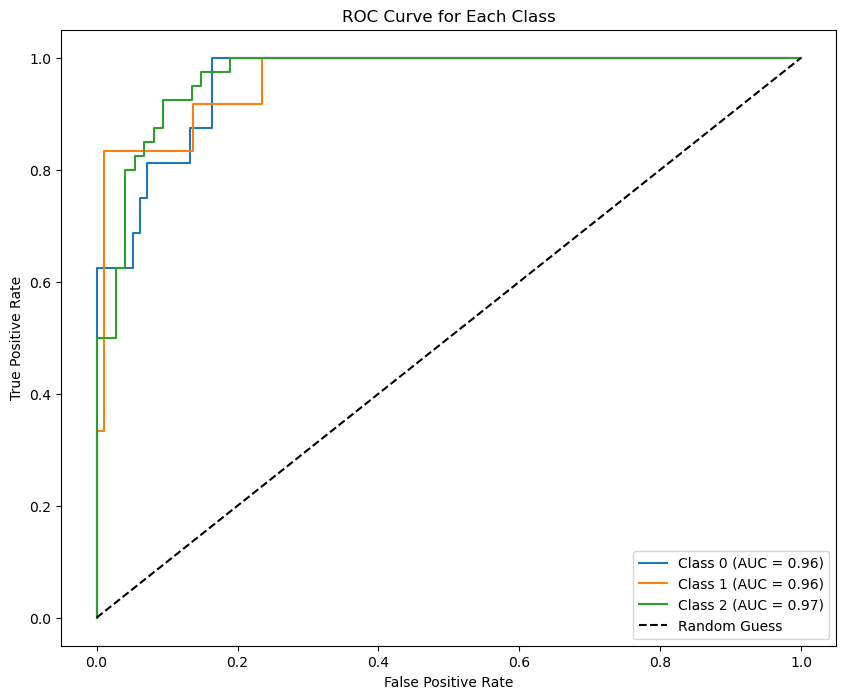

In [17]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Ensure the model is in evaluation mode
model.eval()

# Initialize lists to store labels, predictions, and probabilities
all_labels = []
all_preds = []
all_probs = []

# Disable gradient computation for evaluation
with torch.no_grad():
    for images, labels in val_loader:
        # Move data to the appropriate device (CPU or GPU)
        images, labels = images.to(device), labels.to(device)

        # Get model outputs
        outputs = model(images)

        # Compute probabilities using softmax
        probs = torch.softmax(outputs, dim=1)

        # Get predicted class
        _, predicted = outputs.max(1)

        # Store labels, predictions, and probabilities
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

# Convert to numpy arrays
all_labels = np.array(all_labels)
all_preds = np.array(all_preds)
all_probs = np.array(all_probs)

# Compute ROC Curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}
num_classes = 3  # Adjust this based on the number of classes in your dataset
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(all_labels == i, all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC Curve
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], "k--", label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Each Class")
plt.legend(loc="lower right")
plt.show()

An AUC (Area Under the Curve) score measures the ability of a model to distinguish between classes. The higher the AUC, the better the model is at distinguishing between positive and negative classes.

In your case, you have AUC values of 0.96, 0.96, and 0.97 for three classes. Here's what this indicates:

1. High Discriminatory Power:
An AUC score close to 1 indicates that the model is doing a great job of distinguishing between the classes. The fact that your AUC scores are in the 0.96–0.97 range means your model is very effective at identifying and separating each class from the others.

0.96–0.97 is considered excellent, as it means the model has a high true positive rate and a low false positive rate for each class.

2. Balanced Model Performance Across Classes:
Since the AUC scores for all three classes are in the 0.96–0.97 range, this suggests that your model is performing consistently well across all classes. There's no significant class imbalance or performance discrepancy; the model seems to be learning the patterns for each class equally well.

3. Class-wise Performance:
Each class has a very high AUC, indicating that the model is capable of classifying each class with a very low rate of errors, and the separability between classes is strong.

What Does It Mean for Your Model?
Good Generalization: The high AUC scores suggest that your model is likely generalizing well, especially since these scores are typically evaluated on the validation set (or test set).

Strong Model: The model is effectively distinguishing between each of the three classes, and this level of performance indicates that it’s learned meaningful patterns in the data.

Next Steps:
Monitor for Overfitting: While the AUC scores are excellent, make sure you monitor for overfitting (e.g., by tracking validation accuracy and loss), as this could affect the model’s performance on unseen data, even if AUC remains high.

Continue Tuning: Given the strong AUC performance, you could continue to tune hyperparameters for even better performance or check for any data quality issues that could further enhance the model's robustness.

In summary, these AUC scores suggest that your model is very effective in classifying all three classes, with very good discriminatory power across each one.

In [18]:
# Original class names from ImageFolder (i.e., your folder names)
class_names = dataset.classes

# Auto-group folders by their first 5 characters
folder_to_group = {}
group_names = {}
group_id = 0

for name in class_names:
    key = name[:5]
    if key not in group_names:
        
        group_names[key] = group_id
        group_id += 1
    folder_to_group[name] = group_names[key]

# Map original class indices to merged group indices
index_to_group = {i: folder_to_group[name] for i, name in enumerate(class_names)}

# Remap predictions and labels using merged group indices
all_preds_remapped = np.array([index_to_group[p] for p in all_preds])
all_labels_remapped = np.array([index_to_group[l] for l in all_labels])

# Optional: Get readable group labels for display
merged_class_labels = [f"{k}_*" for k in group_names.keys()]

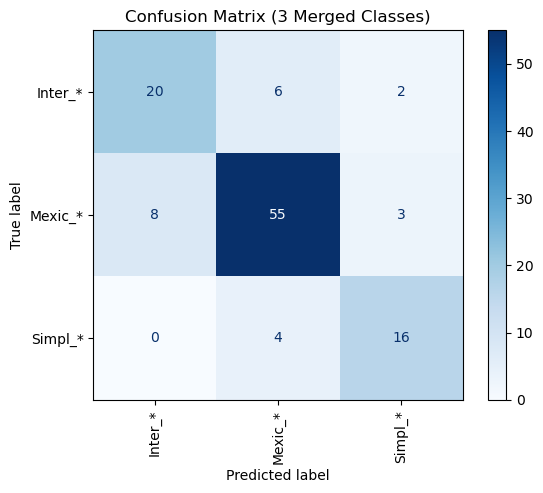

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(all_labels_remapped, all_preds_remapped)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=merged_class_labels)
disp.plot(cmap=plt.cm.Blues, xticks_rotation="vertical")
plt.title("Confusion Matrix (3 Merged Classes)")
plt.show()

# Model Prediction and Saliency

Create a sequence of transformations that resize the image to 224x224 pixels as standard when using pretrained models. Converts to tensor with shape [C, H, W], values scaled from [0,255] to [0.0, 1.0]. This normalizes the color using the ImageNet mean and standard and centers all values around 0 to help the model generalize better.

In [20]:
# Load packages
from PIL import Image
from torchvision import transforms
import torch

# Load the image using PIL
file_path = "/lustre/fs0/bsc4892/skillingsworth/Project/Project/Images/Mexicanus_Uppers_Crop/130.png"
pil_image = Image.open(file_path).convert("RGB")  # Ensure 3-channel RGB image

# Define the transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to the input size expected by the model
    transforms.ToTensor(),          # Convert the image to a PyTorch tensor
    transforms.Normalize(           # Normalize with mean and std (example: ImageNet values)
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]
    )
])


# Apply the transformations
image = transform(pil_image)  # This is now a tensor with shape [C, H, W]

# Add a batch dimension if needed by the model
image = image.unsqueeze(0)  # Shape becomes [1, C, H, W] (batch size = 1)

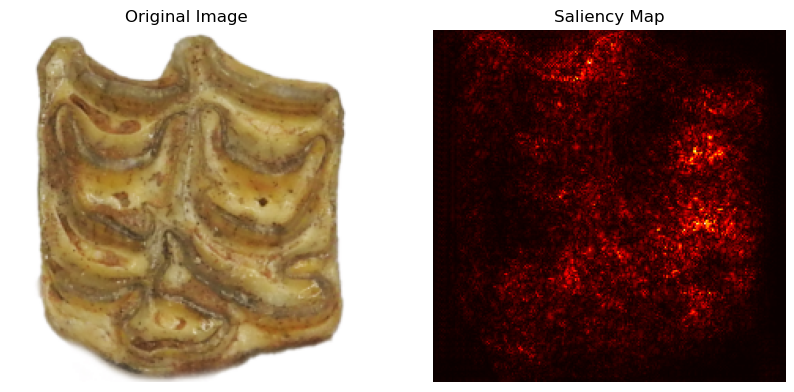

In [21]:
# --- Model Prediction + Saliency ---

import torchvision.transforms.functional as F

image = image.to("cuda").detach().clone()
image.requires_grad_()

model.eval()
model = model.to("cuda")

output = model(image)
predicted_class = output.argmax(dim=1).item()
output[0, predicted_class].backward()

# --- Saliency ---
saliency = image.grad.abs().squeeze()
if saliency.ndim == 3:
    saliency = saliency.max(dim=0)[0]

saliency = (saliency - saliency.min()) / (saliency.max() - saliency.min())

# --- Unnormalize for Display ---
# --- Unnormalize Helper ---
def unnormalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
img_for_plot = unnormalize(image[0].detach().cpu().clone(), mean, std)

# --- Plot ---
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(F.to_pil_image(img_for_plot))
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(saliency.cpu().numpy(), cmap='hot')
plt.title("Saliency Map")
plt.axis("off")
plt.show()
